In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyotp
import pytz
import robin_stocks as r 
totp  = pyotp.TOTP("EKGFWZRXE5SKJWKA").now()
login = r.authentication.login('akshaybhan@email.arizona.edu','AriaArjun@2019',mfa_code=totp)

In [55]:
symbol = 'AAPL'
stock = pd.DataFrame(r.get_stock_historicals(symbol, interval='day', span='5year', bounds='regular', info=None))
#convert timezone to EST/Eastern
est = pytz.timezone('US/Eastern')
utc = pytz.utc
fmt = '%Y-%m-%d %H:%M:%S'
time = pd.to_datetime(stock['begins_at'])
RecTime = time.dt.tz_localize('UTC')
stock['begins_at'] = RecTime.dt.tz_convert('US/Eastern')
stock['begins_at'] =stock['begins_at'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
stock['close_price'] = pd.to_numeric(stock['close_price'])


In [56]:
stock['%change'] = stock['close_price'].pct_change()

In [73]:
#stock.to_csv('stock_TSLA.csv')
data['volume'] = stock['volume']

In [58]:
endDate = stock.iloc[-1,0]
startDate = stock.iloc[1,0]

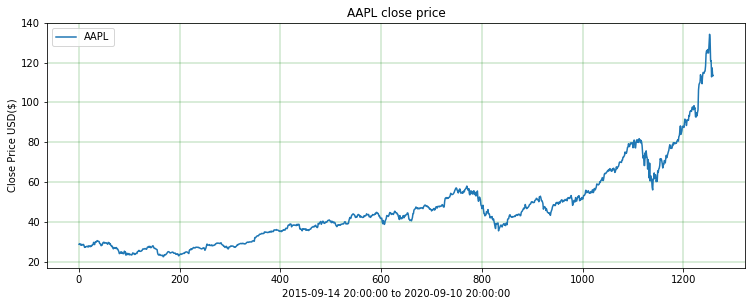

In [59]:
#visualize this data

plt.figure(figsize=(12.5,4.5))
plt.plot(stock['close_price'],label = symbol)
plt.title('{} close price'.format(symbol))
plt.xlabel("{} to {}".format(startDate,endDate))
plt.ylabel("Close Price USD($)")
plt.legend(loc = 'upper left')
plt.grid(color='g', linestyle='-', linewidth=2, alpha = .15)
plt.show()

In [60]:
#create simple moving average with a 30 day window
SMA30 = pd.DataFrame()
SMA30['close_price'] = stock['close_price'].rolling(window = 30).mean()
#SMA30

In [61]:
#create simple moving average with a 100 day window --> Long term average
SMA100 = pd.DataFrame()
SMA100['close_price'] = stock['close_price'].rolling(window = 100).mean()
#create simple moving average with a 100 day window --> Long term average
#EMA100 = pd.DataFrame()
data['EMA14'] = data['stock'].ewm(span = 14).mean()
#SMA100

In [62]:
data['EMA26'] = data['stock'].ewm(span = 26).mean()
data['EMA12'] = data['stock'].ewm(span = 12).mean()
data['MACD'] = data['EMA12']-data['EMA26']

data['MACD_Signal'] = data['MACD'].ewm(span = 9).mean()
#print(data[['MACD','MACD_Signal']])

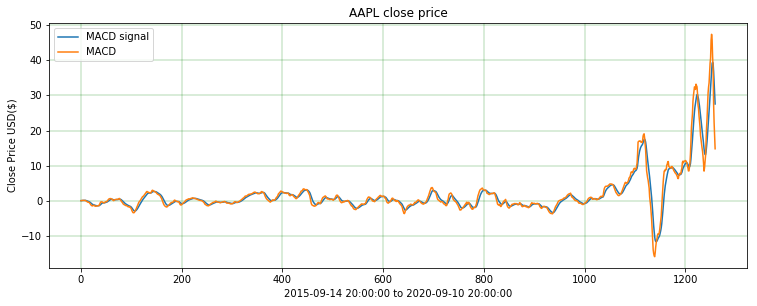

In [63]:
plt.figure(figsize=(12.5,4.5))
#plt.plot(appleYear['close_price'],label = symbol)
plt.plot(data['MACD_Signal'],label = 'MACD signal')
plt.plot(data['MACD'],label = 'MACD')

plt.title('{} close price'.format(symbol))
plt.xlabel("{} to {}".format(startDate,endDate))
plt.ylabel("Close Price USD($)")
plt.legend(loc = 'upper left')
plt.grid(color='g', linestyle='-', linewidth=2, alpha = .15)
plt.show()

In [64]:
def wma_calc(w):
    def g(x):
        return sum(w*x)/sum(w)
    return g

In [65]:
period = 14
weights = list(reversed([(period - n)*period for n in range(period)]))
print(weights)
data['wma'] = data['stock'].rolling(window = 14).apply(wma_calc(weights))

[14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 182, 196]


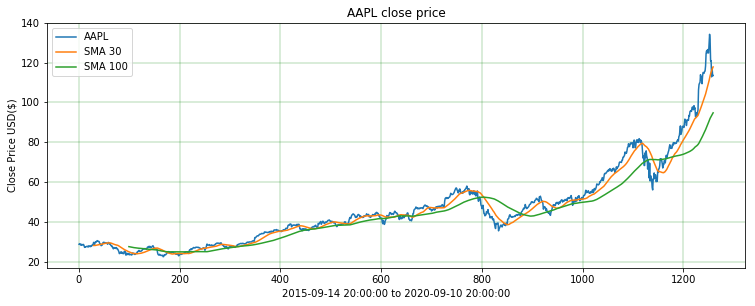

In [66]:
#visulization of the data
#visualize this data

plt.figure(figsize=(12.5,4.5))
plt.plot(stock['close_price'],label = symbol)
plt.plot(SMA30['close_price'],label = 'SMA 30')
plt.plot(SMA100['close_price'],label = 'SMA 100')
#plt.plot(data['EMA14'],label = 'EMA 14')

plt.title('{} close price'.format(symbol))
plt.xlabel("{} to {}".format(startDate,endDate))
plt.ylabel("Close Price USD($)")
plt.legend(loc = 'upper left')
plt.grid(color='g', linestyle='-', linewidth=2, alpha = .15)
plt.show()

In [67]:
#create a Dataframe to store all the data
data = pd.DataFrame()
data['Date'] = stock['begins_at']
data['stock']= stock['close_price']
data['SMA30'] = SMA30['close_price']
data['SMA100'] = SMA100['close_price']

In [68]:
#create a function to signal when to buy and sell the stock
def buy_sell(data):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1
    for i in range (len(data)):
        if data['SMA30'][i] > data['SMA100'][i]:
            if flag != 1:
                sigPriceBuy.append(data['stock'][i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data['SMA30'][i]< data['SMA100'][i]:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data['stock'][i])
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return(sigPriceBuy,sigPriceSell)
            

In [69]:
#store buy and sell data in a data variable
buy_sell = buy_sell(data)
data['Buy_Signal_Price'] = buy_sell[0]
data['Sell_Signal_Price'] = buy_sell[1]


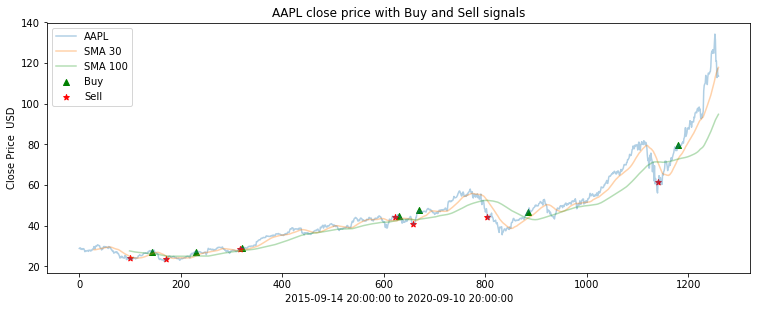

In [70]:
plt.figure(figsize = (12.6,4.6))
plt.plot(data['stock'],label = symbol,alpha = 0.35)
plt.plot(data['SMA30'],label = 'SMA 30',alpha = 0.35)
plt.plot(data['SMA100'],label = 'SMA 100',alpha = 0.35)
plt.scatter(data.index,data['Buy_Signal_Price'],label = 'Buy',marker = '^',color = 'green')
plt.scatter(data.index,data['Sell_Signal_Price'],label = 'Sell',marker = '*',color = 'red')
plt.title('{} close price with Buy and Sell signals'.format(symbol))
plt.xlabel("{} to {}".format(startDate,endDate))
plt.ylabel('Close Price  USD')
plt.legend(loc = 'upper left')
plt.show()

In [71]:
#calculate rsi of the stock
'''
The relative strength index (RSI) is a momentum indicator used in technical analysis
that measures the magnitude of recent price changes 
to evaluate overbought or oversold conditions in the price of a stock or other asset. 

An RSI reading of 30 or below indicates an oversold or undervalued condition.
An RSI reading of 70 or above indicates an overbought or overvalued condition.
'''
data['stock'] = pd.to_numeric(data['stock'])
data['d2d%change'] = data['stock'].diff()
stock
rsi_period = 14
gain = data['d2d%change'].mask(data['d2d%change'] < 0 ,0)
loss = data['d2d%change'].mask(data['d2d%change'] > 0,0)
average_gain = gain.ewm(com=rsi_period -1, min_periods=14).mean()
average_loss = loss.ewm(com=rsi_period -1, min_periods=14).mean()
rs = abs(average_gain/average_loss)
rsi = 100 - (100/(1+rs))
data['rsi'] = rsi
data.iloc[-1,:]


Date                 2020-09-10 20:00:00
stock                             113.49
SMA30                            117.803
SMA100                           94.7651
Buy_Signal_Price                     NaN
Sell_Signal_Price                    NaN
d2d%change                             0
rsi                              45.7865
Name: 1259, dtype: object

                      stock     SMA30    SMA100  Buy_Signal_Price  \
stock              1.000000  0.986714  0.953038          1.000000   
SMA30              0.986714  1.000000  0.975387          0.999097   
SMA100             0.953038  0.975387  1.000000          0.999042   
Buy_Signal_Price   1.000000  0.999097  0.999042          1.000000   
Sell_Signal_Price  1.000000  0.982059  0.977380               NaN   
d2d%change         0.102243  0.047584  0.046849          0.805623   
rsi                0.307794  0.186684  0.080294          0.124059   
volume             0.031482  0.100329  0.192596          0.386838   

                   Sell_Signal_Price  d2d%change       rsi    volume  
stock                       1.000000    0.102243  0.307794  0.031482  
SMA30                       0.982059    0.047584  0.186684  0.100329  
SMA100                      0.977380    0.046849  0.080294  0.192596  
Buy_Signal_Price                 NaN    0.805623  0.124059  0.386838  
Sell_Signal_Price      

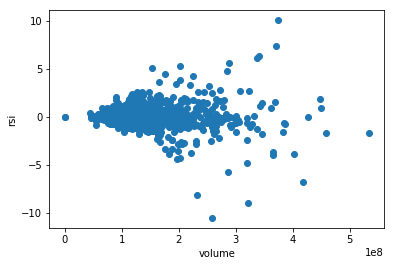

In [74]:
import scipy.stats
data1 = data.copy()
#print(data.shape)
data1.dropna(subset=['volume', 'd2d%change'],axis = 0,inplace = True)
#print(data1.shape)
#print(data1.info())
plt.scatter(data1['volume'],data1['d2d%change'])
print(data1.corr())
#scipy.stats.spearmanr(data1['volume'],data1['d2d%change'])
#print(corr)
plt.xlabel('volume')
plt.ylabel('rsi')
plt.show()

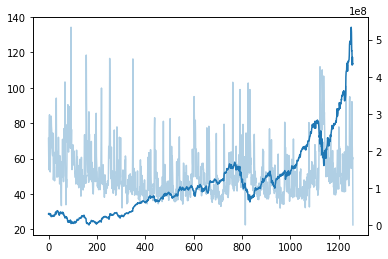

In [76]:
plt.figure(figsize = (12.6,4.6))
fig,ax = plt.subplots()
ax.plot(data['stock'],label = symbol,alpha = 1)
ax2 = ax.twinx()

ax2.plot(data['volume'],label = 'volume',alpha = 0.35)
plt.show()

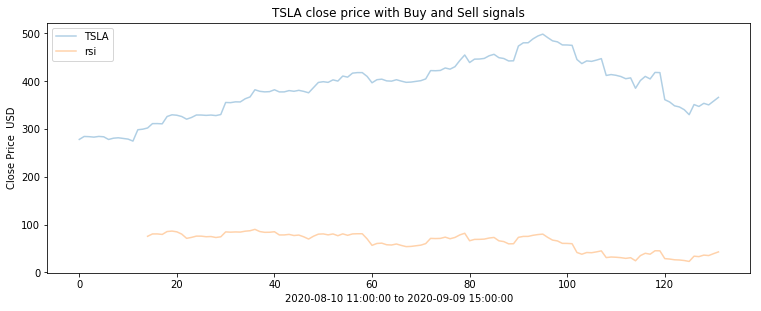

In [80]:
plt.figure(figsize = (12.6,4.6))
plt.plot(data['stock'],label = symbol,alpha = 0.35)
plt.plot(data['rsi'],label = 'rsi',alpha = 0.35)
#plt.plot(data['SMA100'],label = 'SMA 100',alpha = 0.35)
#plt.scatter(data['rsi'],data['Buy_Signal_Price'],label = 'Buy',marker = '^',color = 'green')
#plt.scatter(data.index,data['Sell_Signal_Price'],label = 'Sell',marker = '*',color = 'red')
plt.title('{} close price with Buy and Sell signals'.format(symbol))
plt.xlabel("{} to {}".format(startDate,endDate))
plt.ylabel('Close Price  USD')
plt.legend(loc = 'upper left')
plt.show()